In [17]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using JLD
using StatsBase
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals.jl")
include("NUTS.jl");

In [62]:
#---------------------------
#Load Boston Housing Dataset
#---------------------------
data = load("boston.jld")["boston"]

# Generating test/training sets:
nrow, ncol = size(data)
nrow_test  = div(nrow, 3)
nrow_train = nrow - nrow_test

x = data[:,1:13]
y = data[:,14]

dx = fit(UnitRangeTransform, x; dims=1, unit=true)
StatsBase.transform!(dx, x)
dy = fit(UnitRangeTransform, y; dims=1, unit=true)
StatsBase.transform!(dy, y);

x_raw = x
x = transpose(x)

#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
#network = "classifier"
network = "interpolator"

#Data hyperparameters
n = nrow #Number of samples per mode (classifier)
d = ncol-1 #Input dimension

#Network hyperparameters
k_real = 5 #Number of hidden nodes per layer
k_vector = [0.0 for i=1:k_real]
k_vector[k_real] = 1.0

#Layer hyperparameters
l_range = 4 #Maximum number of layers in the network
l_list = [Int(i) for i in 1:l_range]
l_real = 1

#NUTS
Δmax = 1000;

In [63]:
#Bayesian Neural Net
function G(x, trace)
    activation = relu
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

@gen function interpolator(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical(k_vector), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    α₁ = 0.001 #Gamma Scale for Hyperparameters
    α₂ = 0.1
    α₃ = 1.0
    αᵧ = 0.01
    
    ω₁ = 100
    ω₂ = k_real*100 #Neal (1996): Scaling relationship to # of hidden units
    ωᵧ = k_real*100
    τ₁ ~ gamma(ω₁,α₁) #Hidden Weights
    τ₂ ~ gamma(ω₁,α₂) #Hidden Biases
    τ₃ ~ gamma(ω₂,α₃) #Output Weights
    τᵧ ~ gamma(ωᵧ,α₂) #Noise Parameter for y
    #τ₄ ~ gamma() #Output Biases - Neal uses fixed sigmas here
    
    #Standard Deviations
    σ₁ = 1/τ₁
    σ₂ = 1/τ₂
    σ₃ = 1/τ₃
    σᵧ = 1/τᵧ
    
    #println(σᵧ)
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            if i == 1
                Σ = Diagonal([σ₁ for i=1:length(μ)])
            else
                Σ = Diagonal([σ₃ for i=1:length(μ)])
            end
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = ones(k[i])
            Σ2 = Diagonal([σ₂ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₃ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = ones(1)
            Σ2ₒ = Diagonal([1.0 for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Regression Likelihood
    y = @trace(mvnormal(vec(scores), Diagonal([σᵧ for i=1:length(x[1,:])])), (:y))

    return scores
    
end;

#(best_trace,) = generate(interpolator, (x,), obs)
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])

test_scores = interpolator(x);

In [64]:
#Register Observed Data - Bernoulli
obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;

scores = []
mses = []
ks = []
best_traces = []
(best_trace,) = generate(interpolator, (x,), obs)
best_score = get_score(best_trace)
best_pred_y = Flux.σ.(G(x, best_trace))
best_mse = mse_regression(best_pred_y, y)
println(1/best_trace[:τᵧ])

0.01907796654870187


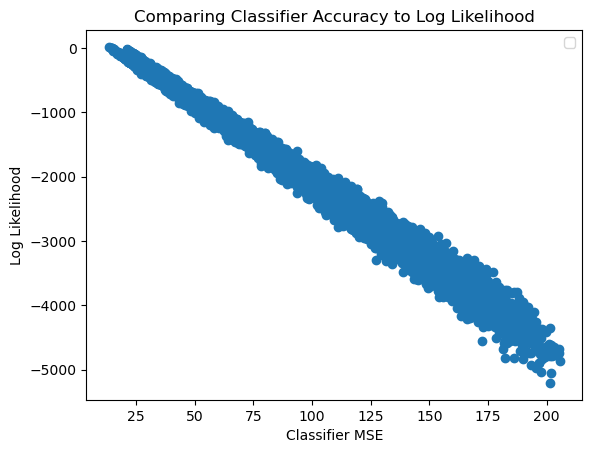

No handles with labels found to put in legend.


PyObject <matplotlib.legend.Legend object at 0x7f6e2a299e10>

In [65]:
#----------------
#Test Likelihood
#----------------
function likelihood(best_trace, best_mse, best_score)
    obs = obs_master;
    (trace,) = generate(interpolator, (x,), obs)
    
    pred_y = Flux.σ.(G(x, trace))
    mse = mse_regression(pred_y, y)
    score = get_score(trace)
    
    if mse > best_mse
        best_mse = mse
        best_score = score
        best_trace = trace
        best_pred_y = pred_y
    end
    push!(scores,score)
    push!(mses,mse)
    return(best_trace, best_mse, best_score)
end;

for i=1:10000
    best_trace, best_mse, best_score = likelihood(best_trace, best_mse, best_score)
end

PyPlot.scatter(mses, scores)
plt.title("Comparing Classifier Accuracy to Log Likelihood")
plt.xlabel("Classifier MSE")
plt.ylabel("Log Likelihood")
#plt.ylim(-100,1)
plt.legend()

In [72]:
#--------------------
#RJMCMC - using HMC
#--------------------
traces = []
scores = []
acc = []
acc_l = []
acc_w = []
l_results = []
epss = []
l = 10
ϵ = 0.001

function within_move(trace, iters, obs, prev_trace)
    selection = select_selection(trace)
    score1 = get_score(prev_trace)
    (new_trace, hmc_score) = hmc_mod(trace, selection, L=l, eps=ϵ, check=false, observations=obs)
    
    score2 = get_score(new_trace)
    #println("new trace score: $score2")
    #println("old trace score: $score1")
    acc_score = score2 - score1
    #println("Calc score: $acc_score")
    #println("hmc_score: $hmc_score")
    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        #println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        obs = obs_master;
        if i%50 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.0
            (trace) = layer_move(trace, 3, obs, prev_trace)
        else
            (trace) = within_move(trace, 10, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(l_results, trace[:l])
    end
    println("Finished")
end
 
runs = 2000

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs_master[:l] = 4
obs = obs_master;
(starting_trace,) = generate(interpolator, (x,), obs)
#starting_trace = best_trace

include("NUTS.jl");
rjmcmc(starting_trace,runs);

Beginning RJMCMC
Starting ks: [5, 5, 5, 5]
--------------------------------
Epoch 50 Within Acceptance Prob: 0.4897959183673469
Epoch 100 Within Acceptance Prob: 0.5656565656565656
Epoch 150 Within Acceptance Prob: 0.5771812080536913
Epoch 200 Within Acceptance Prob: 0.6080402010050251
Epoch 250 Within Acceptance Prob: 0.6104417670682731
Epoch 300 Within Acceptance Prob: 0.6153846153846154
Epoch 350 Within Acceptance Prob: 0.6131805157593123
Epoch 400 Within Acceptance Prob: 0.6265664160401002
Epoch 450 Within Acceptance Prob: 0.623608017817372
Epoch 500 Within Acceptance Prob: 0.6232464929859719
Epoch 550 Within Acceptance Prob: 0.6229508196721312
Epoch 600 Within Acceptance Prob: 0.6110183639398998
Epoch 650 Within Acceptance Prob: 0.6194144838212635
Epoch 700 Within Acceptance Prob: 0.6123032904148784
Epoch 750 Within Acceptance Prob: 0.6234979973297731
Epoch 800 Within Acceptance Prob: 0.6270337922403004
Epoch 850 Within Acceptance Prob: 0.6230859835100118
Epoch 900 Within Acceptan

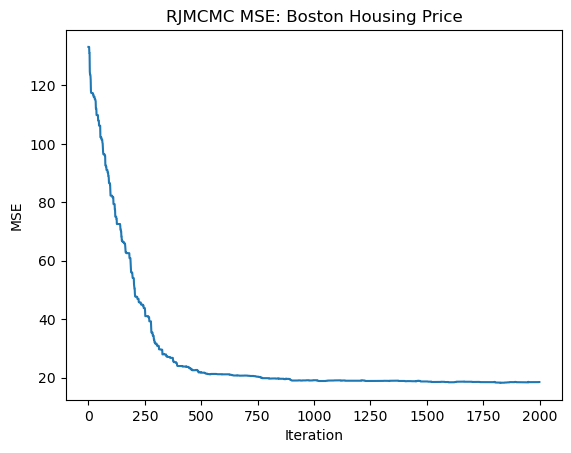

In [71]:
#Plot MSE Scores by Trace
mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(G(x,trace))
    mse = mse_regression(pred_y, y)

    push!(mses,mse)
end

plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");

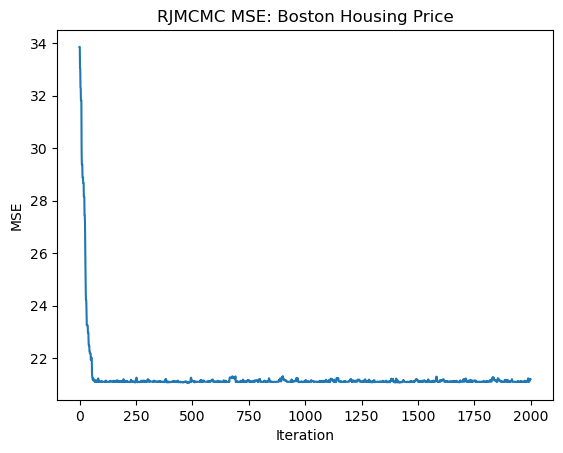

In [73]:
#Plot MSE Scores by Trace
mses = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = Flux.σ.(G(x,trace))
    mse = mse_regression(pred_y, y)

    push!(mses,mse)
end

plot(mses)
plt.title("RJMCMC MSE: Boston Housing Price")
plt.xlabel("Iteration")
plt.ylabel("MSE");

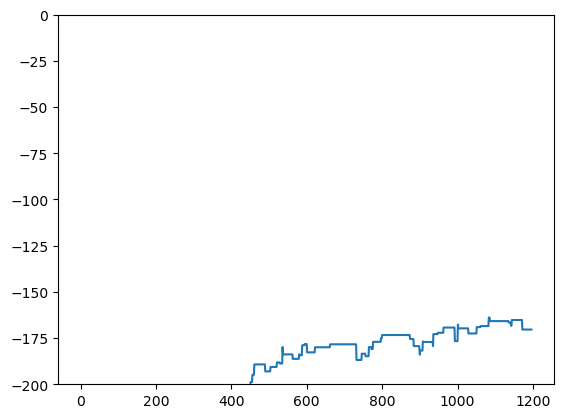

(-200.0, 0.0)

In [50]:
scores = [get_score(trace) for trace in traces]
plot(scores)
plt.ylim(-200,0)

In [107]:
#--------------------
#RJMCMC - using NUTS
#--------------------
traces = []
scores = []
acc = []
acc_l = []
acc_w = []
l_results = []
epss = []

function within_move(trace, iters, obs, prev_trace)
    selection = select_selection(trace)
    (new_trace, hmc_score) = NUTS2(trace, selection, false, obs, iters, 0, prev_trace)
    #println(hmc_score)
    if rand(Uniform(0,1)) < exp(hmc_score)
        trace = new_trace
        accepted = 1.0
        println("Accepted")
    else
        trace = prev_trace
        accepted = 0.0
        #println("Not Accepted")
    end
    #push!(traces, trace)
    push!(acc, accepted)
    push!(acc_w, accepted)
    #accepted && println("Within accepted")
    return trace
end

function layer_move(trace, iters, obs, prev_trace)
    
    #Determine birth or death
    current_l = trace[:l]
    
    if current_l == last(l_list)
        move_type = 0
    elseif current_l == l_list[1]
        move_type = 1
    else
        move_type = bernoulli(0.5)
    end
    move = "Empty"
    
    obs_master = choicemap()::ChoiceMap
    obs_master[:y] = y

    #HMC Move 1
    selection = select_selection(trace)
    hmc1_trace = trace
    (hmc1_trace, hmc1_score) = NUTS(hmc1_trace, selection, false, obs, iters, iters, prev_trace)

    #RJ Move
    if move_type == 1
        move = "Birth"
        rj_trace = layer_birth(hmc1_trace)
    else
        move = "Death"
        rj_trace = layer_death(hmc1_trace)
    end

    #HMC Move 2
    hmc2_trace = rj_trace
    (hmc2_trace, hmc2_score) = NUTS(hmc2_trace, selection, false, obs, iters, iters, hmc2_trace)

    score1 = get_score(prev_trace)
    score2 = get_score(hmc2_trace)
    logscore = (score2 - score1)
    score = exp(logscore) #+ hmc1_score - hmc2_score)
    #println("$move: $score")
    
    if rand(Uniform(0,1)) < score
        accepted = true
        trace = hmc2_trace
        println("New ks accepted! Current ks: $trace[:l]")
    else
        println("Sticking with the old l!")
        accepted = false
        trace = prev_trace
    end

    #println("$move Old Trace: $score1; Pre-HMC: $score_test; Post-HMC: $score2")
        
    push!(acc, accepted)
    push!(acc_l, accepted)
    push!(scores, score)
    return trace
end


function rjmcmc(starting_trace, iters)
    trace = starting_trace
    l = trace[:l]
    ks = [trace[(:k,i)] for i=1:trace[:l]]
    println("Beginning RJMCMC")
    println("Starting ks: $ks")
    println("--------------------------------")

    for i=1:iters
        l = trace[:l]
        obs = obs_master;
        if i%10 == 0
            #println("Epoch $i Acceptance Prob: $(sum(acc)/length(acc))")
            #println("Epoch $i layer count: $l, ks: $ks")
            println("Epoch $i Within Acceptance Prob: $(sum(acc_w)/length(acc_w))")
            #println("Epoch $i Layer Acceptance Prob: $(sum(acc_l)/length(acc_l))")
            #println([trace[(:k,i)] for i=1:trace[:l]])
        end
        
        #Gibbs sampling for hyperparameters
        prev_trace = trace
        trace, obs = select_hyperparameters(prev_trace, obs)
        
        #Indicator variable for move type
        u = rand(Uniform(0,1))
        if u > 1.0
            (trace) = layer_move(trace, 3, obs, prev_trace)
        else
            (trace) = within_move(trace, 10, obs, prev_trace)
        end
        push!(traces, trace)
        push!(scores, get_score(trace))
        push!(l_results, trace[:l])
    end
    println("Finished")
end
 
runs = 2

obs_master = choicemap()::ChoiceMap
obs_master[:y] = y
obs = obs_master;
(starting_trace,) = generate(interpolator, (x,), obs)
#starting_trace = best_trace

include("NUTS.jl");
rjmcmc(starting_trace,runs);

Beginning RJMCMC
Starting ks: [8]
--------------------------------
Epsilon for iter 1: 0.5
Negative potential energy: 52.27142198501883
Score: 0.0
0
Epsilon for iter 2: 0.5
Negative potential energy: 48.82030442780701
Score: 0.0
0
Epsilon for iter 3: 0.5
Negative potential energy: 66.11158634592869
Score: 0.0
0
Epsilon for iter 4: 0.5
Negative potential energy: 50.2729001312146
Score: 0.0
0
Epsilon for iter 5: 0.5
Negative potential energy: 59.59426686656641
Score: 0.0
0
Epsilon for iter 6: 0.5
Negative potential energy: 63.69241594774495
Score: 0.0
0
Epsilon for iter 7: 0.5
Negative potential energy: 56.96012759185305
Score: 0.0
0
Epsilon for iter 8: 0.5
Negative potential energy: 50.01348536512743
Score: 0.0
0
Epsilon for iter 9: 0.5
Negative potential energy: 70.26521102482641
Score: 0.0
0
Epsilon for iter 10: 0.5
Negative potential energy: 59.284225936694014
Score: 0.0
0
Epsilon for iter 1: 0.5
Negative potential energy: 58.631533820337836
Score: 0.0
0
Epsilon for iter 2: 0.5
Negat

In [105]:
#-----------------
#New NUTS Function
#-----------------

function NUTS2(trace, selection::Selection, check, observations, M, Madapt, prev_trace)
    
    function find_reasonable_epsilon(θ)
        ϵ = 1 #initialize ϵ
        r = sample_momenta(length(θ))
        θ¹,r¹,new_trace = leapfrog(θ,r,ϵ)
        score_comparison = exp(get_score(new_trace) - get_score(trace))
        score_indicator = (score_comparison > 0.5) ? 1.0 : 0.0
        a = 2.0*(score_indicator) - 1.0
        while score_comparison^a > 2^(-a)
            ϵ = (2^a)*ϵ
            θ¹,r¹,new_trace2 = leapfrog(θ,r,ϵ)
            score_comparison = exp(get_score(new_trace2) - get_score(new_trace))
        end
        return ϵ
    end

    function L(θ)
        new_trace = trace
        args = get_args(new_trace)
        argdiffs = map((_) -> NoChange(), args)
        retval_grad = accepts_output_grad(get_gen_fn(new_trace)) ? zero(get_retval(new_trace)) : nothing
        (_, vals, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
        θ_update = from_array(vals, θ)
        (new_trace, _, _) = update(new_trace, args, argdiffs, θ_update)
        get_score(new_trace)
    end

    #Tree Building for Efficient NUTS
    function build_tree(θ,r,u,v,j,ϵ,θ⁰,r⁰)
        #Base case - take one leapfrog step in the direction of v
        if j == 0
            θ¹,r¹,tree_trace = leapfrog(θ,r,v*ϵ)
            prev_score = L(θ⁰) - 0.5(dot(r⁰,r⁰))
            score = get_score(tree_trace) - 0.5(dot(r¹,r¹))

            n¹ = (log(u) ≤ score) ? 1 : 0
            s¹ = (log(u) < Δmax + score) ? 1 : 0
            α¹ = min(1, exp(score-prev_score))
            return θ¹,r¹,θ¹,r¹,θ¹,n¹,s¹,α¹,1
        #Recursion - build left and right subtrees
        else
            θ⁻,r⁻,θ⁺,r⁺,θ¹,n¹,s¹,α¹,nᵅ¹ = build_tree(θ,r,u,v,j-1,ϵ,θ⁰,r⁰)
            if s¹ == 1
                if v == -1
                    θ⁻,r⁻,_,_,θ²,n²,s²,α²,nᵅ² = build_tree(θ⁻,r⁻,u,v,j-1,ϵ,θ⁰,r⁰)
                else
                    _,_,θ⁺,r⁺,θ²,n²,s²,α²,nᵅ² = build_tree(θ⁺,r⁺,u,v,j-1,ϵ,θ⁰,r⁰)
                end
                met_ind = n²/(n¹+n²)
                #println("Acceptance prob: $met_ind")
                if bernoulli(met_ind) == true
                    θ¹ = θ²
                else
                    θ¹ = θ¹
                end
                α¹ = α¹ + α²
                nᵅ¹ = nᵅ¹ + nᵅ²
                i¹ = (dot((θ⁺ - θ⁻),r⁻) ≥ 0) ? 1 : 0
                i² = (dot((θ⁺ - θ⁻),r⁺) ≥ 0) ? 1 : 0
                s¹ = s²*i¹*i²
                n¹ = n¹ + n²
            end
           return θ⁻,r⁻,θ⁺,r⁺,θ¹,n¹,s¹,α¹,nᵅ¹
        end
    end;

    function leapfrog(θ,r,ϵ)
        #Prep trace and gradient
        new_trace = trace
        args = get_args(trace)
        argdiffs = map((_) -> NoChange(), args)
        retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
        θtrace = from_array(vals, θ)
        (new_trace, _, _) = update(new_trace, args, argdiffs, θtrace)
        (_, values_trie, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
        gradient = to_array(gradient_trie, Float64)

        #LEAPFROG

        r += (ϵ / 2) * gradient # half step on momenta
        θ += ϵ * r # full step on positions

        # get new gradient
        θnew = from_array(values_trie, θ)
        (new_trace, _, _) = update(new_trace, args, argdiffs, θnew)
        (_, _, gradient_trie) = choice_gradients(new_trace, selection, retval_grad)
        gradient = to_array(gradient_trie, Float64)

        r += (ϵ / 2) * gradient # half step on momenta

        return θ,r,new_trace
    end
    
    #Get vals structure
    args = get_args(trace)
    retval_grad = accepts_output_grad(get_gen_fn(trace)) ? zero(get_retval(trace)) : nothing
    argdiffs = map((_) -> NoChange(), args)
    (_, vals, gradient_trie) = choice_gradients(trace, selection, retval_grad)
    
    #Initialize θ, r
    θ⁰ = to_array(vals, Float64)
    r⁰ = sample_momenta(length(θ⁰))
    θ = θ⁰
    θᵐ = θ
    r = r⁰
    new_trace = trace
    
    #Previous scores
    prev_model_score = get_score(prev_trace)
    prev_momenta_score = assess_momenta(r⁰)
        
    #Initialize ϵ
    ϵ⁰ = find_reasonable_epsilon(θ⁰)
    μ = log(10*ϵ⁰);ϵ¹=1;H⁰=0;γ=0.05;t⁰=10;κ=0.75;δ=0.65
    #println("Epsilon: $ϵ")
        
    #Loop M times
    for m=1:M
        #Resample momentum Variables
        println("Epsilon for iter $m: $ϵ⁰")
        m == 1 ? (r = r⁰) : (r = sample_momenta(length(θ)))
        params = from_array(vals, θ)
        (new_trace, _, _) = update(new_trace, args, argdiffs, params)
        momenta_score = assess_momenta(r)
        neg = 0.5(dot(r,r))
        println("Negative potential energy: $neg")
        score = exp(get_score(new_trace) - 0.5(dot(r,r)))
        println("Score: $score")
        
        if score <= 0
            u = 0
        else
            u = rand(Uniform(0,score))
        end
        println(u)
        
        #Initialize
        θ¹ = θ; θ⁻ = θ; θ⁺ = θ; r⁻ = r; r⁺ = r; j = 0; s = 1; n = 1; nᵅ = 0; α = 0
        
        while s == 1
            vⱼ = rand([-1,1])
            if vⱼ == -1
                θ⁻,r⁻,_,_,θ¹,n¹,s¹,α,nᵅ = build_tree(θ⁻,r⁻,u,vⱼ,j,ϵ⁰,θ,r)
                #println("Alpha: $α")
                #println("N Alpha: $nᵅ")
            else
                _,_,θ⁺,r⁺,θ¹,n¹,s¹,α,nᵅ = build_tree(θ⁺,r⁺,u,vⱼ,j,ϵ⁰,θ,r)
                #println("Alpha: $α")
                #println("N Alpha: $nᵅ")
            end
            if s¹ == 1
                met_ind = (n¹/n > 1.0) ? 1.0 : n¹/n
                if bernoulli(met_ind) == true
                    θᵐ = θ¹
                else
                    θᵐ = θᵐ
                end
            end
            n = n + n¹
            i¹ = (dot((θ⁺ - θ⁻),r⁻) ≥ 0) ? 1 : 0
            i² = (dot((θ⁺ - θ⁻),r⁺) ≥ 0) ? 1 : 0
            s = s¹*i¹*i²
            j += 1
        end
            
        if m ≤ Madapt
            H⁰ = ((1-(1/(m+t₀)))*H⁰)+((1/(m+t₀))*(δ-(α/nᵅ)))
            ϵ⁰ = exp(μ - (√m)/γ * H⁰)
            ϵ¹ = exp(m^(-κ)*log(ϵ⁰) + (1-m^(-κ))*log(ϵ¹))
            #ϵ⁰ = ϵ⁰
        else
            ϵ⁰ = ϵ⁰
        end
        
            
    end
    
    θ = from_array(vals, θᵐ)
    momenta = r
    (new_trace, _, _) = update(new_trace, args, argdiffs, θ)
    
    new_model_score = get_score(new_trace) # assess new model score (negative potential energy)
    new_momenta_score = assess_momenta(-momenta) # assess new momenta score (negative kinetic energy)

    # accept or reject
    alpha = new_model_score - prev_model_score + new_momenta_score - prev_momenta_score
    (new_trace, alpha)
end;

In [ ]:
println(traces[1][(:W,1)])
println(traces[2][(:W,1)])

println(get_score(traces[1]))
println(get_score(traces[2]))